In [1]:
import warp as wp
import numpy as np

wp.init()

num_points = 1024

@wp.kernel
def length(points: wp.array(dtype=wp.vec3),
           lengths: wp.array(dtype=float)):

    # thread index
    tid = wp.tid()
    
    # compute distance of each point from origin
    lengths[tid] = wp.length(points[tid])


# allocate an array of 3d points
points = wp.array(np.random.rand(num_points, 3), dtype=wp.vec3)
lengths = wp.zeros(num_points, dtype=float)

# launch kernel
wp.launch(kernel=length,
          dim=len(points),
          inputs=[points, lengths])

print(lengths)

Warp 0.11.0 initialized:
   CUDA Toolkit: 11.5, Driver: 12.4
   Devices:
     "cpu"    | Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
     "cuda:0" | NVIDIA GeForce RTX 4070 Ti SUPER (sm_89)
   Kernel cache: C:\Users\ojbsn\AppData\Local\NVIDIA Corporation\warp\Cache\0.11.0
Module __main__ load on device 'cuda:0' took 5.26 ms
[1.1621996 1.0682312 1.2848661 ... 1.1790142 0.9563093 1.1144384]


Module warp.utils load on device 'cuda:0' took 13.60 ms
Module __main__ load on device 'cuda:0' took 478.61 ms
Module warp.render.utils load on device 'cuda:0' took 12.42 ms
Module warp.render.render_opengl load on device 'cuda:0' took 20.65 ms
update took 1.19 ms
render took 1.43 ms
update took 0.58 ms
render took 1.23 ms


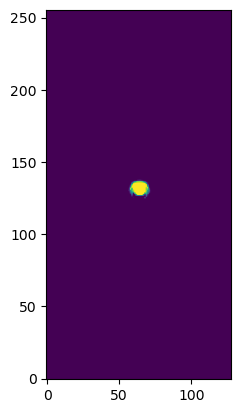

In [2]:
import math

import warp as wp
import warp.render

wp.init()

grid_width = wp.constant(256)
grid_height = wp.constant(128)


@wp.func
def lookup_float(f: wp.array2d(dtype=float), x: int, y: int):
    x = wp.clamp(x, 0, grid_width - 1)
    y = wp.clamp(y, 0, grid_height - 1)

    return f[x, y]


@wp.func
def sample_float(f: wp.array2d(dtype=float), x: float, y: float):
    lx = int(wp.floor(x))
    ly = int(wp.floor(y))

    tx = x - float(lx)
    ty = y - float(ly)

    s0 = wp.lerp(lookup_float(f, lx, ly), lookup_float(f, lx + 1, ly), tx)
    s1 = wp.lerp(lookup_float(f, lx, ly + 1), lookup_float(f, lx + 1, ly + 1), tx)

    s = wp.lerp(s0, s1, ty)
    return s


@wp.func
def lookup_vel(f: wp.array2d(dtype=wp.vec2), x: int, y: int):
    if x < 0 or x >= grid_width:
        return wp.vec2()
    if y < 0 or y >= grid_height:
        return wp.vec2()

    return f[x, y]


@wp.func
def sample_vel(f: wp.array2d(dtype=wp.vec2), x: float, y: float):
    lx = int(wp.floor(x))
    ly = int(wp.floor(y))

    tx = x - float(lx)
    ty = y - float(ly)

    s0 = wp.lerp(lookup_vel(f, lx, ly), lookup_vel(f, lx + 1, ly), tx)
    s1 = wp.lerp(lookup_vel(f, lx, ly + 1), lookup_vel(f, lx + 1, ly + 1), tx)

    s = wp.lerp(s0, s1, ty)
    return s


@wp.kernel
def advect(
    u0: wp.array2d(dtype=wp.vec2),
    u1: wp.array2d(dtype=wp.vec2),
    rho0: wp.array2d(dtype=float),
    rho1: wp.array2d(dtype=float),
    dt: float,
):
    i, j = wp.tid()

    u = u0[i, j]

    # trace backward
    p = wp.vec2(float(i), float(j))
    p = p - u * dt

    # advect
    u1[i, j] = sample_vel(u0, p[0], p[1])
    rho1[i, j] = sample_float(rho0, p[0], p[1])


@wp.kernel
def divergence(u: wp.array2d(dtype=wp.vec2), div: wp.array2d(dtype=float)):
    i, j = wp.tid()

    if i == grid_width - 1:
        return
    if j == grid_height - 1:
        return

    dx = (u[i + 1, j][0] - u[i, j][0]) * 0.5
    dy = (u[i, j + 1][1] - u[i, j][1]) * 0.5

    div[i, j] = dx + dy


@wp.kernel
def pressure_solve(p0: wp.array2d(dtype=float), p1: wp.array2d(dtype=float), div: wp.array2d(dtype=float)):
    i, j = wp.tid()

    s1 = lookup_float(p0, i - 1, j)
    s2 = lookup_float(p0, i + 1, j)
    s3 = lookup_float(p0, i, j - 1)
    s4 = lookup_float(p0, i, j + 1)

    # Jacobi update
    err = s1 + s2 + s3 + s4 - div[i, j]

    p1[i, j] = err * 0.25


@wp.kernel
def pressure_apply(p: wp.array2d(dtype=float), u: wp.array2d(dtype=wp.vec2)):
    i, j = wp.tid()

    if i == 0 or i == grid_width - 1:
        return
    if j == 0 or j == grid_height - 1:
        return

    # pressure gradient
    f_p = wp.vec2(p[i + 1, j] - p[i - 1, j], p[i, j + 1] - p[i, j - 1]) * 0.5

    u[i, j] = u[i, j] - f_p


@wp.kernel
def integrate(u: wp.array2d(dtype=wp.vec2), rho: wp.array2d(dtype=float), dt: float):
    i, j = wp.tid()

    # gravity
    f_g = wp.vec2(-90.8, 0.0) * rho[i, j]

    # integrate
    u[i, j] = u[i, j] + dt * f_g

    # fade
    rho[i, j] = rho[i, j] * (1.0 - 0.1 * dt)


@wp.kernel
def init(rho: wp.array2d(dtype=float), u: wp.array2d(dtype=wp.vec2), radius: int, dir: wp.vec2):
    i, j = wp.tid()

    d = wp.length(wp.vec2(float(i - grid_width / 2), float(j - grid_height / 2)))

    if d < radius:
        rho[i, j] = 1.0
        u[i, j] = dir


class Example:
    def __init__(self, **kwargs):
        self.device = wp.get_device()

        self.sim_fps = 60.0
        self.sim_substeps = 2
        self.iterations = 100
        self.sim_dt = (1.0 / self.sim_fps) / self.sim_substeps
        self.sim_time = 0.0

        self.device = wp.get_device()

        shape = (grid_width, grid_height)

        self.u0 = wp.zeros(shape, dtype=wp.vec2)
        self.u1 = wp.zeros(shape, dtype=wp.vec2)

        self.rho0 = wp.zeros(shape, dtype=float)
        self.rho1 = wp.zeros(shape, dtype=float)

        self.p0 = wp.zeros(shape, dtype=float)
        self.p1 = wp.zeros(shape, dtype=float)
        self.div = wp.zeros(shape, dtype=float)

        # capture pressure solve as a CUDA graph
        if self.device.is_cuda:
            wp.capture_begin(self.device)
            try:
                self.pressure_iterations()
            finally:
                self.graph = wp.capture_end(self.device)

    def update(self):
        with wp.ScopedTimer("update"):
            for _ in range(self.sim_substeps):
                shape = (grid_width, grid_height)
                dt = self.sim_dt

                speed = 400.0
                angle = math.sin(self.sim_time * 4.0) * 1.5
                vel = wp.vec2(math.cos(angle) * speed, math.sin(angle) * speed)

                # update emitters
                wp.launch(init, dim=shape, inputs=[self.rho0, self.u0, 5, vel])

                # force integrate
                wp.launch(integrate, dim=shape, inputs=[self.u0, self.rho0, dt])
                wp.launch(divergence, dim=shape, inputs=[self.u0, self.div])

                # pressure solve
                self.p0.zero_()
                self.p1.zero_()

                if self.device.is_cuda:
                    wp.capture_launch(self.graph)

                else:
                    self.pressure_iterations()

                # velocity update
                wp.launch(pressure_apply, dim=shape, inputs=[self.p0, self.u0])

                # semi-Lagrangian advection
                wp.launch(advect, dim=shape, inputs=[self.u0, self.u1, self.rho0, self.rho1, dt])

                # swap buffers
                (self.u0, self.u1) = (self.u1, self.u0)
                (self.rho0, self.rho1) = (self.rho1, self.rho0)

                self.sim_time += dt

    def render(self):
        pass

    def pressure_iterations(self):
        for _ in range(self.iterations):
            wp.launch(pressure_solve, dim=self.p0.shape, inputs=[self.p0, self.p1, self.div])

            # swap pressure fields
            (self.p0, self.p1) = (self.p1, self.p0)

    def update_and_render_frame(self, frame_num=None, img=None):
        self.update()

        with wp.ScopedTimer("render"):
            if img:
                img.set_array(self.rho0.numpy())

        return (img,)


if __name__ == "__main__":
    import matplotlib
    import matplotlib.animation as anim
    import matplotlib.pyplot as plt

    example = Example()

    fig = plt.figure()

    img = plt.imshow(example.rho0.numpy(), origin="lower", animated=True, interpolation="antialiased")
    img.set_norm(matplotlib.colors.Normalize(0.0, 1.0))
    seq = anim.FuncAnimation(
        fig, example.update_and_render_frame, fargs=(img,), frames=100000, blit=True, interval=8, repeat=False
    )

    plt.show()